In [1]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
Final_DF = pd.read_csv("./Final_DF.csv")

In [3]:
Final_DF.head()

,Date,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,BTC_Price,ETH_Price,SOL_Price,XRP_Price
0,2020-04-10,99.519997,1662.50,0.05,0.729,41.67,6865.493164,158.412445,0.951054,0.187464
1,2020-04-11,99.519997,1662.50,0.05,0.729,41.67,6859.083008,158.216019,0.776819,0.188063
2,2020-04-12,99.519997,1662.50,0.05,0.729,41.67,6971.091797,161.142426,0.882507,0.190135
3,2020-04-13,99.349998,1662.50,0.05,0.770,41.17,6845.037598,156.279556,0.777832,0.187732
4,2020-04-14,98.889999,1715.85,0.05,0.750,37.76,6842.427734,157.596390,0.661925,0.185335


In [6]:
# forecasr BTC Price
Final_DF['Date'] = pd.to_datetime(Final_DF['Date'])

In [7]:
Final_DF['id'] = "BTC"

In [8]:
Final_DF["time_idx"] = Final_DF["Date"].dt.year * 12 + Final_DF["Date"].dt.month
Final_DF["time_idx"] -= Final_DF["time_idx"].min()

In [10]:
Final_DF["month"] = Final_DF.Date.dt.month.astype(str).astype("category")

In [26]:
print(Final_DF.groupby("id")["time_idx"].nunique())  # Check number of unique time_idx per group

id
BTC    58
Name: time_idx, dtype: int64


In [27]:
Final_DF["time_idx"] = Final_DF.groupby("id").cumcount()

In [28]:
print(Final_DF.isnull().sum())

Date             0
Dollar_Index     0
Gold_Price       0
Interest_Rate    0
US_10_Year       0
VIX_Value        0
BTC_Price        0
ETH_Price        0
SOL_Price        0
XRP_Price        0
id               0
time_idx         0
month            0
dtype: int64


In [29]:
print(Final_DF.groupby("id")["time_idx"].max())

id
BTC    1735
Name: time_idx, dtype: int64


In [30]:
max_prediction_length = 7
max_encoder_length = 30
training_cutoff = Final_DF["time_idx"].max() - max_prediction_length

In [31]:
training = TimeSeriesDataSet(
    Final_DF[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="BTC_Price",
    group_ids=["id"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["id"],
    static_reals=[],
    time_varying_known_categoricals=["month"],
    time_varying_known_reals=["time_idx", "Dollar_Index", "Gold_Price", "Interest_Rate", "US_10_Year", "VIX_Value", "ETH_Price", "SOL_Price", "XRP_Price"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["BTC_Price"],
    target_normalizer=GroupNormalizer(
        groups=["id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    # allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, Final_DF, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## Create Baseline Model

In [32]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

C:\Users\Sathmika\AppData\Local\Temp\ipykernel_3784\2174382858.py:2: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\

tensor(2210.1741)

## Find Optimal Learning Rate

In [33]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    # optimizer="Ranger",
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 14.0k


c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  super().__init__(loss=loss, logging_metrics=logging_metrics, **kwargs)


c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Con

suggested learning rate: 0.011481536214968821


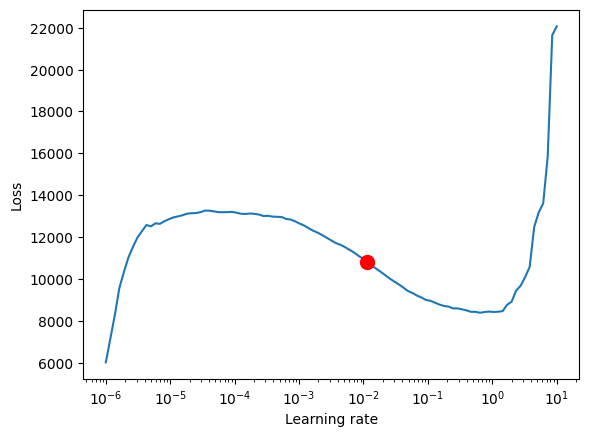

C:\Users\Sathmika\AppData\Local\Temp\ipykernel_3784\4268711780.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [34]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [35]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    # optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 30.3k


c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is i

In [36]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 73     | train
3  | prescalers                         | ModuleDict                      | 224    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.7 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 6.9 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s, v_num=5, train_loss_step=577.0, val_loss=906.0, train_loss_epoch=543.0]     


## Evaluate Peroformance

In [37]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [40]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Validation MAE: 1498.40625


C:\Users\Sathmika\AppData\Local\Temp\ipykernel_3784\493137810.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")


In [41]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


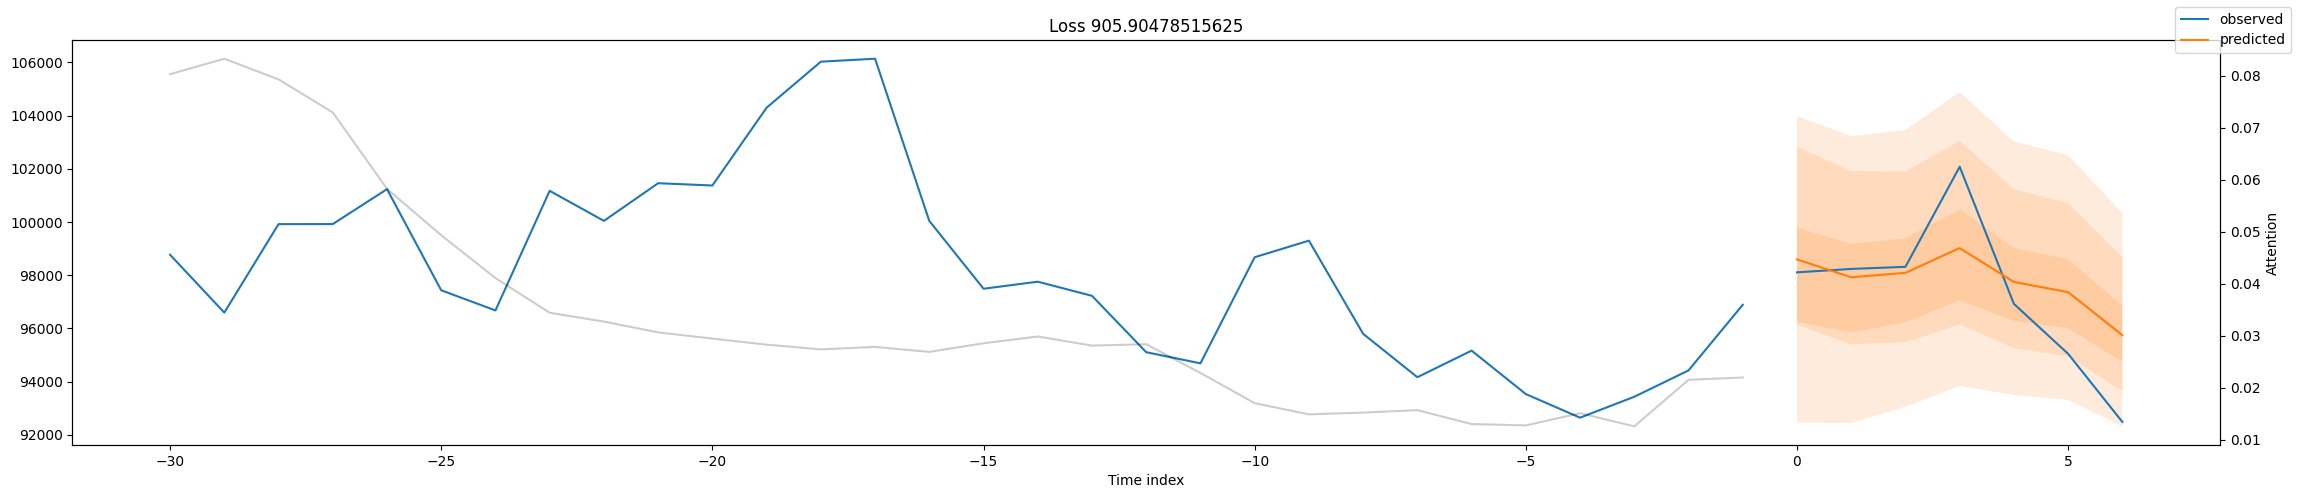

In [42]:

# Plot actuals vs prediction and attention
# for idx in range(val_predictions.prediction.shape[0]):
from matplotlib import pyplot as plt


for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax)

In [64]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [65]:
raw_predictions

Prediction(output=Output(prediction=tensor([[[ 92457.2891,  96131.2969,  96246.7109,  98594.5703,  99784.7578,
          102835.2812, 103980.7500],
         [ 92445.0000,  95401.5547,  95857.6719,  97923.0938,  99174.5859,
          101906.1875, 103229.7578],
         [ 93051.6406,  95482.6406,  96226.5781,  98088.5156,  99393.8438,
          101898.4219, 103465.1250],
         [ 93832.5078,  96144.4766,  97052.5938,  99021.1875, 100472.5469,
          103052.1406, 104883.9062],
         [ 93494.9922,  95255.5000,  96280.9844,  97746.4922,  99020.5156,
          101226.9766, 103029.8750],
         [ 93307.7969,  94948.8359,  96013.5938,  97362.8125,  98602.6406,
          100710.9062, 102510.8594],
         [ 92317.0625,  93638.5000,  94747.3438,  95746.1875,  96841.4766,
           98673.8594, 100333.5703]]]), encoder_attention=tensor([[[[0.0606, 0.0588, 0.0597, 0.0613, 0.0530, 0.0470, 0.0416, 0.0382,
           0.0362, 0.0348, 0.0338, 0.0336, 0.0335, 0.0338, 0.0275, 0.0280,
         

## Hypeparameter Tuning

In [45]:
# Hyperparameters Tuning with Optuna
# create study
import pickle


study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# pickle study results
with open("study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
study.best_trial.params

[I 2025-01-26 17:16:57,439] A new study created in memory with name: no-name-abd35897-bf22-480e-8e53-26d394dc1533
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:161: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout=trial.suggest_uniform("dropou

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-01-26 17:22:32,353] Trial 1 finished with value: 1260.0987548828125 and parameters: {'gradient_clip_val': 0.18457965021778797, 'hidden_size': 24, 'dropout': 0.13404234264798448, 'hidden_continuous_size': 21, 'attention_head_size': 3, 'learning_rate': 0.004211515840229828}. Best is trial 1 with value: 1260.0987548828125.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[I 2025-01-26 17:23:04,431] Trial 2 pruned. Trial was pruned at epoch 4.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[I 2025-01-26 17:24:42,949] Trial 3 pruned. Trial was pruned at epoch 16.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[I 2025-01-26 17:24:52,299] Trial 4 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU 

{'gradient_clip_val': 0.01671995974550211,
 'hidden_size': 123,
 'dropout': 0.1440639702291752,
 'hidden_continuous_size': 26,
 'attention_head_size': 3,
 'learning_rate': 0.0011885947346794575}

## Reatrain the Model using suggested parameteres

In [46]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val= 0.01671995974550211,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0011885947346794575,
    hidden_size=123,
    attention_head_size=3,
    dropout=0.1440639702291752,
    hidden_continuous_size=26,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    # optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 980.9k


In [47]:
# fit network with new parameters
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 73     | train
3  | prescalers                         | ModuleDict                      | 728    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 26.9 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 101 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 92.2 K | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 61.3 K | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 61.3 K 

c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 28: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s, v_num=6, train_loss_step=475.0, val_loss=1.66e+3, train_loss_epoch=523.0]   


In [49]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path_optimized = trainer.checkpoint_callback.best_model_path
best_tft_optimized = TemporalFusionTransformer.load_from_checkpoint(best_model_path_optimized)

c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [50]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft_optimized.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Validation MAE: 3142.11279296875


c:\Users\Sathmika\anaconda3\envs\tft\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\Sathmika\AppData\Local\Temp\ipykernel_3784\2128631815.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")


In [51]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
val_prediction_results = best_tft_optimized.predict(val_dataloader, mode="raw", return_x=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


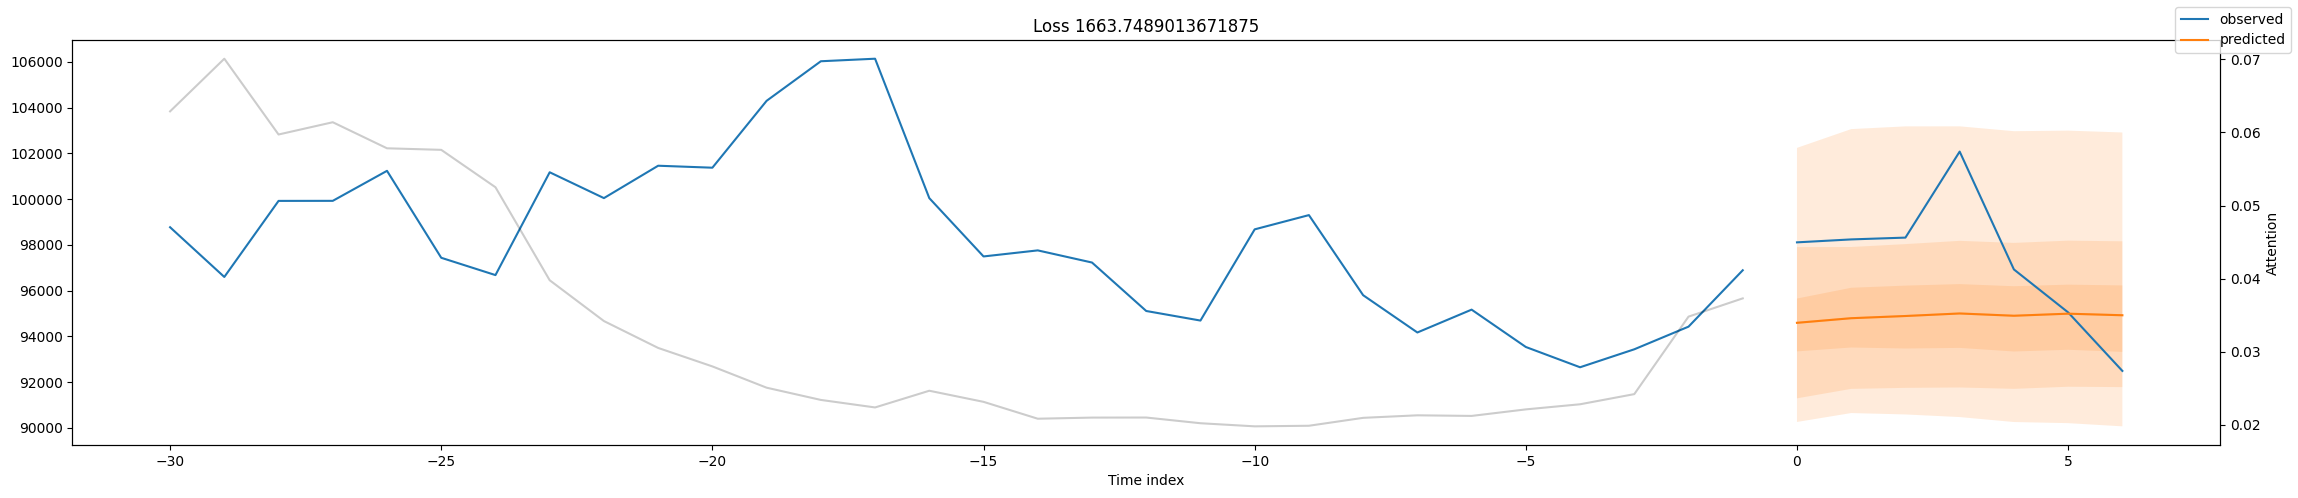

In [54]:
# Plot actuals vs prediction and attention
# for idx in range(val_predictions.prediction.shape[0]):
from matplotlib import pyplot as plt


for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft_optimized.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax)

In [56]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft_optimized.predict(val_dataloader, mode="raw", return_x=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


IndexError: index 1 is out of bounds for dimension 0 with size 1

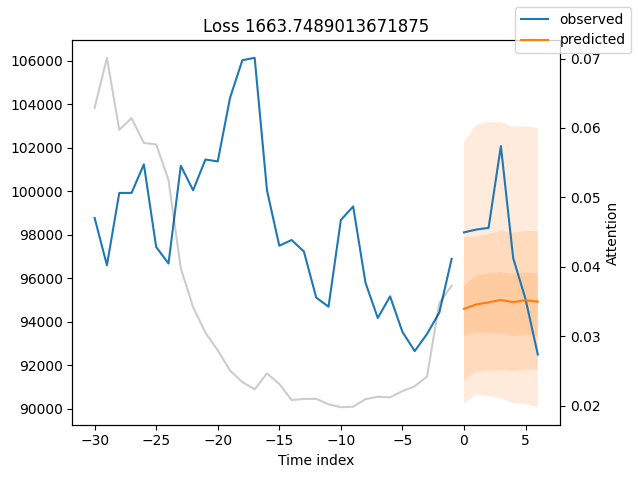

In [57]:
for idx in range(10):  # plot 10 examples
    best_tft_optimized.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)